# Importing Packages
#### Various python library is imported and the directory of MODFLOW executables for model simulation is also imported

In [1]:
%matplotlib inline
from pylab import *
import flopy.modflow as mf
import flopy.utils as fu
import flopy.plot as fp
import scipy.special as sp
import pandas as pd
import time

#from ttim import *
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
%matplotlib inline

import os
workspace = os.path.join('data')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)

import platform
binpath = '/Users/ihasan/Modflow/src/' #MODFLOW executables directory
exe_name = os.path.join(binpath, 'mf2005') #exe name of the MODFLOW executables in the directory
if platform.system() == 'Windows':
    exe_name += '.exe'
print ('Model executable: ', exe_name)

flopy is installed in /Users/ihasan/anaconda3/lib/python3.7/site-packages/flopy
Model executable:  /Users/ihasan/Modflow/src/mf2005


## <u>Aquifer features</u>

__Aquifer thickness H = 20 m__

__Hydraulic conductivity k = 10 m/d__

__Porosity n = 0.3__

__Aquifer water density = 1025 kg/m3__

__Fresh water injection and recovery rate = 2000 m3/d__

__Injection time = 15 day__

__Dimensionless parameter D = 20__

__Dimensionless injection time $\tau_{inj}$ = 0.625__

__Radius of the well = 0.2 m__


# Model setup
#### Model papremeters and different data have been setup in a function so that the model can be simulated in a loop for optimazation

In [2]:
def modeliter(rp, zi, ihead, toe, tip):    
    # Step 1_Creating model
    modelname = '1D_ASR_2lyr_no_storage'
    ml = mf.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace)

    #Step 2_Defining discritization                                                             
    nr=1500         #Total time step for recovery period
    #rp=529        #Time step of recovery for each cycle
    tj=[0.0001, 0.01, 0.01, 0.01] #Length of time step in day
    n=[200,1498,rp, abs(nr-rp)]

    dels4=50.0*np.ones(238)
    dels3=5.0*np.ones(31)
    dels2=np.ones(5) 
    dels1=0.2*np.ones(3) #for all other model this value is 21
    dels=np.hstack((dels1,dels2,dels3,dels4))
    
    ncol = len(dels)
    nrow = 1
    nlay = 2
    nper = 4
    perlen=np.hstack((tj[0]*n[0], tj[1]*n[1], tj[2]*n[2], tj[3]*n[3]))

    nstp =n
    stt=False
    steady = [stt,stt,stt,stt]
    delr, delc = dels, 1
    top = 0
    botm = [-10., -20.]
    discret = mf.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol, laycbd=[0,0],
                            delr=delr, delc=delc, top=top, botm=botm,
                            nper=nper, perlen=perlen, nstp=nstp,steady=steady)

    y,x,z=discret.get_node_coordinates()

    #Step 3_Defining basic model
    # bas data
    ibound = np.ones((nlay, nrow, ncol), dtype= np.int)
    ibound[:,0,-1]=-1

    # initial head data
    bas = mf.ModflowBas(ml, ibound=ibound, strt=ihead)


    #Step 4_Defining layer properties data

    laytyp=[0,0]
    hk=10.
    vka=10.
    ss=1e-5
    ssz=0.3 #Effective porosity
    sy=0.15
    
    kj=np.ones((nlay,nrow,ncol))
    vkj=np.ones((nlay,nrow,ncol))
    sj=np.ones((nlay,nrow,ncol))
    sz=np.ones((nlay,nrow,ncol))
    syj=np.ones((nlay,nrow,ncol))
        
    for i in range(ncol):
        for k in range(nlay):
            kj[k,0,i]=x[i]*2*np.pi*hk
            vkj[k,0,i]=x[i]*2*np.pi*vka
            sj[k,0,i]=x[i]*2.*np.pi*ss
            sz[k,0,i]=x[i]*2*np.pi*ssz
            syj[k,0,i]=x[i]*2*np.pi*sy
        
    lpf = mf.ModflowLpf(ml, laytyp=laytyp, hk=kj, vka=vkj, ss=sj,layavg=2,sy=syj, storagecoefficient=False)

    #Step 5_Adding additional package to simulate acquifer features

    # well data
    inj1=[[0, 0, 0, 2000.]]
    inj2=[[0, 0, 0, 2000.]]
    rec=[[0, 0, 0, -2000.]]
    idl2=[[0, 0, 0, 0.]]

    # create well dictionary
    well_data={0:inj1, 1:inj2, 2:rec, 3:idl2}
    wel = mf.ModflowWel(ml, stress_period_data=well_data)

    #swi2 data
    nsrf=1
    istrat=1 
    toeslope=toe 
    tipslope=tip
    nu=[0, 0.025]

    isource=np.zeros((nlay,nrow, ncol))
    isource[0,0,0]=1
    nsolver=1

    swi = mf.ModflowSwi2(ml, nsrf=nsrf, istrat=istrat, toeslope=toeslope, tipslope=tipslope, nu=nu, iswizt = 55,
                         zeta=[zi], ssz=sz, isource=isource, nsolver=nsolver)
    ocd = {}
    for ot in range(nper):
        for st in range(n[ot]):
            ocd[ot,st] = ['save head', 'print budget']
    oc =mf.mfoc.ModflowOc(ml, stress_period_data =ocd)
    pcg = mf.ModflowPcg(ml)
    ml.write_input()
    ml.run_model(silent='.')
    
    # read model heads
    hfile = fu.HeadFile(os.path.join(ml.model_ws, modelname+'.hds'))
    head = hfile.get_alldata()
    # read model zeta
    zfile = fu.CellBudgetFile(os.path.join(ml.model_ws, modelname+'.zta'))
    kstpkper = zfile.get_kstpkper()
    zeta = []
    for kk in kstpkper:
        zeta.append(zfile.get_data(kstpkper=kk, text='ZETASRF  1')[0])
    zeta = np.array(zeta)
    return zeta, n, x, head

# Interface slope correction
#### The interface toe and tip slope has been corrected by this function at every simulation

In [3]:
def midv(midmin, midmax, matr):
    abc=matr[3197][0][0]
    #abc = matr
    lgc1=np.argwhere(abc<=midmax)[:,0]
    lgc2=np.argwhere(abc>=midmin)[:,0]
    cmn = np.intersect1d(lgc1, lgc2)
    #print (lgc1, lgc2)
    if len(cmn)>0:
        cmn1=cmn[int(len(cmn)/2)]
        slope=abs((abc[cmn1-1]-abc[cmn1+1])/(x[cmn1-1]-x[cmn1+1]))  
    #else:
     #   if np.size(lgc1)==0:
            #slope = 0.2
    else:
        slope=abs((abc[lgc1[-1]]-abc[lgc2[0]])/(x[lgc1[-1]]-x[lgc2[0]]))

    if slope>2:
        slope = 0.2
    return slope

# Model simulation

In [4]:
strt = time.time()
nlay=2
nrow=1
ncol=3+5+31+238
zi = np.zeros((nlay,nrow, ncol), np.float)
hd=np.zeros((nlay,nrow,ncol), np.float)
zi[0,0,0]=-0.1
zi[0,0,1]=-0.1
zi[1,0,0]=-10.1
ran=700
rp=700 #Number of steps of recovery phase
rt=1500
toe=0.05
tip=0.05

zetas=[]
heads=[]
rcstps=[]

for k in range(10):
    for i in range(20):
        result=modeliter(rp, zi, hd, toe, tip)
        x=result[2]
        surface=result[0]
        step=result[1]
        ncn=np.hstack((np.cumsum(step))).astype(np.int64)
        trl=surface[ncn[2]-1,1,0,:22]
        ttip=midv(-6, -4, surface)
        print ('slope ',ttip)
        toe=ttip#[0]
        tip=ttip#[0]
        print ('c=',k+1,',s=',i+1)
        if trl[0]>-10.1:
            print ('initial break')
            rp=rp-20
            for j in range(21):
                result=modeliter(rp, zi, hd, toe, tip)
                surface=result[0]
                head=result[3]
                step=result[1]
                ncn=np.hstack((np.cumsum(step))).astype(np.int64)
                trl=surface[ncn[2]-1,1,0,:22]
                ttip=midv(-6, -4, surface)
                toe=ttip#[0]
                tip=ttip#[0]
                print ('cb=',j+1)
                if trl[0]>-10.1:
                    print ('cycle break')
                    zetas.append(surface)
                    zi=surface[-1]
                    
                    #zi[1][0][zi[1][0]==-10]=np.nan
                    #indc=np.hstack(np.argwhere(zi[1][0]<0))
                    #zi[0][0][indc[0]:indc[-1]+1]= zi[1][0][indc[0]:indc[-1]+1]
                    #zi[1][0]=zi[0][0]
                    
                    hd=head[-1]
                    rcstps.append(rp)
                    heads.append(head)
                    print ('Recovery phase steps',rp, 'Cycle-',k+1, 'Efficiency-', rp/15)
                    #print ('Slope = ', toe)
                    break
                else:
                    rp+=1
            break
        else:
            rp+=20


n=result[1]
stp=sum(n)
rtime = (time.time()-strt)/60
print ('{} Minutes and {} Seconds'.format(int(rtime), np.round(((rtime-int(rtime))*60),2)))

slope  0.3333005428314209
c= 1 ,s= 1
slope  0.3278116464614868
c= 1 ,s= 2
slope  0.32629992961883547
c= 1 ,s= 3
slope  0.3245291233062744
c= 1 ,s= 4
slope  0.3015892028808594
c= 1 ,s= 5
slope  0.30176386833190916
c= 1 ,s= 6
slope  0.3006769895553589
c= 1 ,s= 7
slope  0.2996483325958252
c= 1 ,s= 8
initial break
cb= 1
cb= 2
cb= 3
cb= 4
cb= 5
cb= 6
cb= 7
cb= 8
cb= 9
cb= 10
cb= 11
cb= 12
cycle break
Recovery phase steps 831 Cycle- 1 Efficiency- 55.4
slope  0.2787346124649048
c= 2 ,s= 1
slope  0.27868778705596925
c= 2 ,s= 2
slope  0.27772705554962157
c= 2 ,s= 3
slope  0.27672295570373534
c= 2 ,s= 4
slope  0.2757350206375122
c= 2 ,s= 5
slope  0.27475881576538086
c= 2 ,s= 6
slope  0.27371313571929934
c= 2 ,s= 7
slope  0.27264132499694826
c= 2 ,s= 8
slope  0.27155170440673826
c= 2 ,s= 9
slope  0.2704355239868164
c= 2 ,s= 10
slope  0.269085955619812
c= 2 ,s= 11
initial break
cb= 1
cb= 2
cb= 3
cycle break
Recovery phase steps 1013 Cycle- 2 Efficiency- 67.53333333333333
slope  0.2374577760696411


# Result visualization

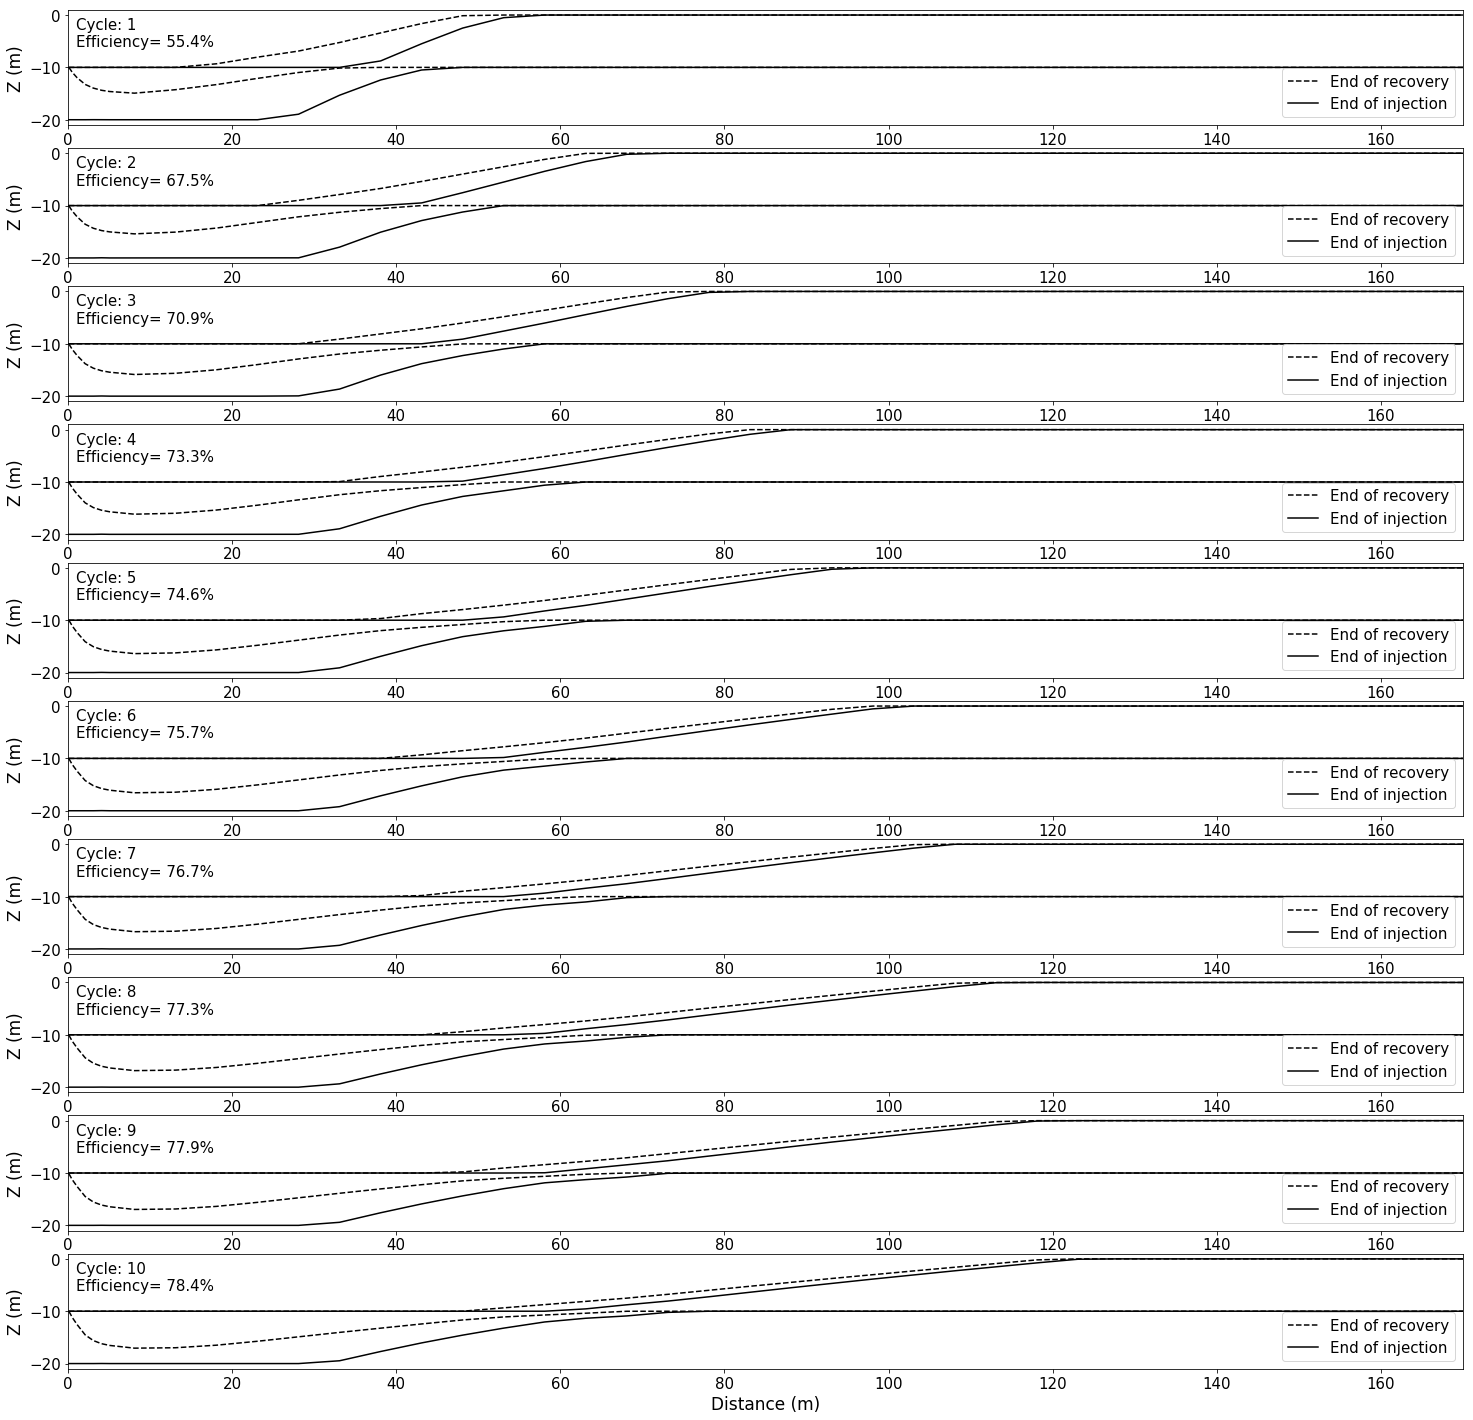

In [6]:
rcstps=np.array(rcstps,dtype=np.int)
allstp=np.zeros(40,dtype=np.int)
for i in range(10):
    allstp[4*i+0]=200
    allstp[4*i+1]=1498
    allstp[4*i+2]=int(rcstps[i])
    allstp[4*i+3]=int(1500-rcstps[i])

ncn=np.array(np.hstack((np.cumsum(allstp))))
plt.figure(figsize=(25,25))

for i in range(10):
    eff=(rcstps[i]/1500)*100
    tl="Cycle: %d"%(i+1)
    txts=tl+'\n'+'Efficiency= %.1f'%eff+'%'
    plt.subplot(10,1,i+1)
    plt.plot(x,zetas[i][1698+rcstps[i]-1][0][0], 'k--', label='End of recovery')
    plt.plot(x,zetas[i][1698+rcstps[i]-1][1][0], 'k--')
    plt.plot(x,zetas[i][1698-1][0][0], 'k-', label='End of injection')
    plt.plot(x,zetas[i][1698-1][1][0], 'k-')
    plt.ylabel('Z (m)', fontsize=17)
    ytk=np.linspace(-20,0,3)
    plt.xticks(fontsize=15)
    plt.yticks(ytk, fontsize=15)
    plt.xlim(0,170)
    plt.legend(loc=4, fontsize=15)
    plt.text(1,-6, txts, fontsize=15)
plt.xlabel('Distance (m)', fontsize=17);